In [1]:
#From https://github.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/blob/main/Chapter_13.ipynb

import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

from scipy import linalg 

from sklearn.linear_model import LinearRegression

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation 

from castle.algorithms import PC, GES
from castle.algorithms import ANMNonlinear, ICALiNGAM, DirectLiNGAM
from castle.algorithms import Notears, NotearsNonlinear, GOLEM

from castle.common.priori_knowledge import PrioriKnowledge

from castle.common.independence_tests import hsic_test

import matplotlib.pyplot as plt

from dowhy import gcm
import pandas as pd

2024-01-23 16:41:07,700 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'totalBandwidth'),
                           ('ihave', 'gossipBandwidth'),
                           ('iwant', 'gossipBandwidth'),
                           ('gossipBandwidth', 'totalBandwidth'),
                           ('messageReceived', 'messageBandwidth'),
                           ('messageBandwidth', 'totalBandwidth')
                         ])

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [30]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})#, 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# consolidated = consolidated.diff().dropna()

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
#                   'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
0,1856.745902,3748.0,520.0,0.0,0.0,0.0,0.0,521.0,8512.0,4243.0,8,6,12,4,8,2,0.25,1.0,0
1,1979.913793,478.0,59.0,0.0,0.0,0.0,347.0,59.0,1234.0,697.0,8,6,12,4,8,2,0.25,1.0,0
2,1670.648148,3986.0,542.0,0.0,0.0,0.0,0.0,547.0,9027.0,4494.0,8,6,12,4,8,2,0.25,1.0,0
3,1710.708333,472.0,72.0,0.0,0.0,0.0,351.0,72.0,1259.0,715.0,8,6,12,4,8,2,0.25,1.0,0
4,1879.665217,3703.0,503.0,0.0,0.0,0.0,0.0,505.0,8369.0,4161.0,8,6,12,4,8,2,0.25,1.0,0
5,1723.305556,538.0,73.0,0.0,0.0,0.0,347.0,73.0,1385.0,774.0,8,6,12,4,8,2,0.25,1.0,0
6,1816.257895,3430.0,465.0,0.0,0.0,0.0,0.0,465.0,7774.0,3879.0,8,6,12,4,8,2,0.25,1.0,0
7,1556.234783,786.0,115.0,0.0,0.0,0.0,342.0,115.0,1956.0,1055.0,8,6,12,4,8,2,0.25,1.0,0
8,2597.587302,3456.0,460.0,0.0,0.0,0.0,0.0,464.0,7833.0,3913.0,8,6,12,4,8,2,0.25,1.0,0
9,1654.754386,779.0,115.0,0.0,0.0,0.0,343.0,115.0,1947.0,1053.0,8,6,12,4,8,2,0.25,1.0,0


In [13]:
#Differenting -> https://medium.com/@nathanvenos/time-series-analysis-in-python-ab582dd803cd

consolidateddiff = consolidated.diff().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidateddiff.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
1,123.167891,-3270.0,-461.0,0.0,0.0,0.0,347.0,-462.0,-7278.0,-3546.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-309.265645,3508.0,483.0,0.0,0.0,0.0,-347.0,488.0,7793.0,3797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.060185,-3514.0,-470.0,0.0,0.0,0.0,351.0,-475.0,-7768.0,-3779.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,168.956884,3231.0,431.0,0.0,0.0,0.0,-351.0,433.0,7110.0,3446.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-156.359662,-3165.0,-430.0,0.0,0.0,0.0,347.0,-432.0,-6984.0,-3387.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,92.952339,2892.0,392.0,0.0,0.0,0.0,-347.0,392.0,6389.0,3105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-260.023112,-2644.0,-350.0,0.0,0.0,0.0,342.0,-350.0,-5818.0,-2824.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1041.352519,2670.0,345.0,0.0,0.0,0.0,-342.0,349.0,5877.0,2858.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-942.832916,-2677.0,-345.0,0.0,0.0,0.0,343.0,-349.0,-5886.0,-2860.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,888.890775,2667.0,342.0,0.0,0.0,0.0,-343.0,348.0,5846.0,2831.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


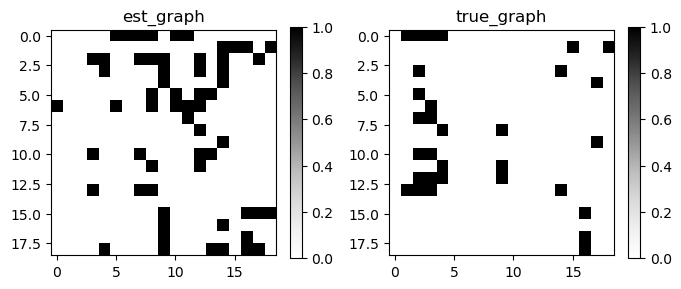

{'fdr': 0.8644, 'tpr': 0.2581, 'fpr': 0.3643, 'shd': 69, 'nnz': 59, 'precision': 0.1333, 'recall': 0.2581, 'F1': 0.1758, 'gscore': 0.0}


In [9]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
# priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
#                             (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
#                             (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
#                             (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
#                             (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
#                             (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
#                             (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
#                             (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
#                             (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
#                             (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15),(14,4),(16,17),(16,18)])
# priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original')#, priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

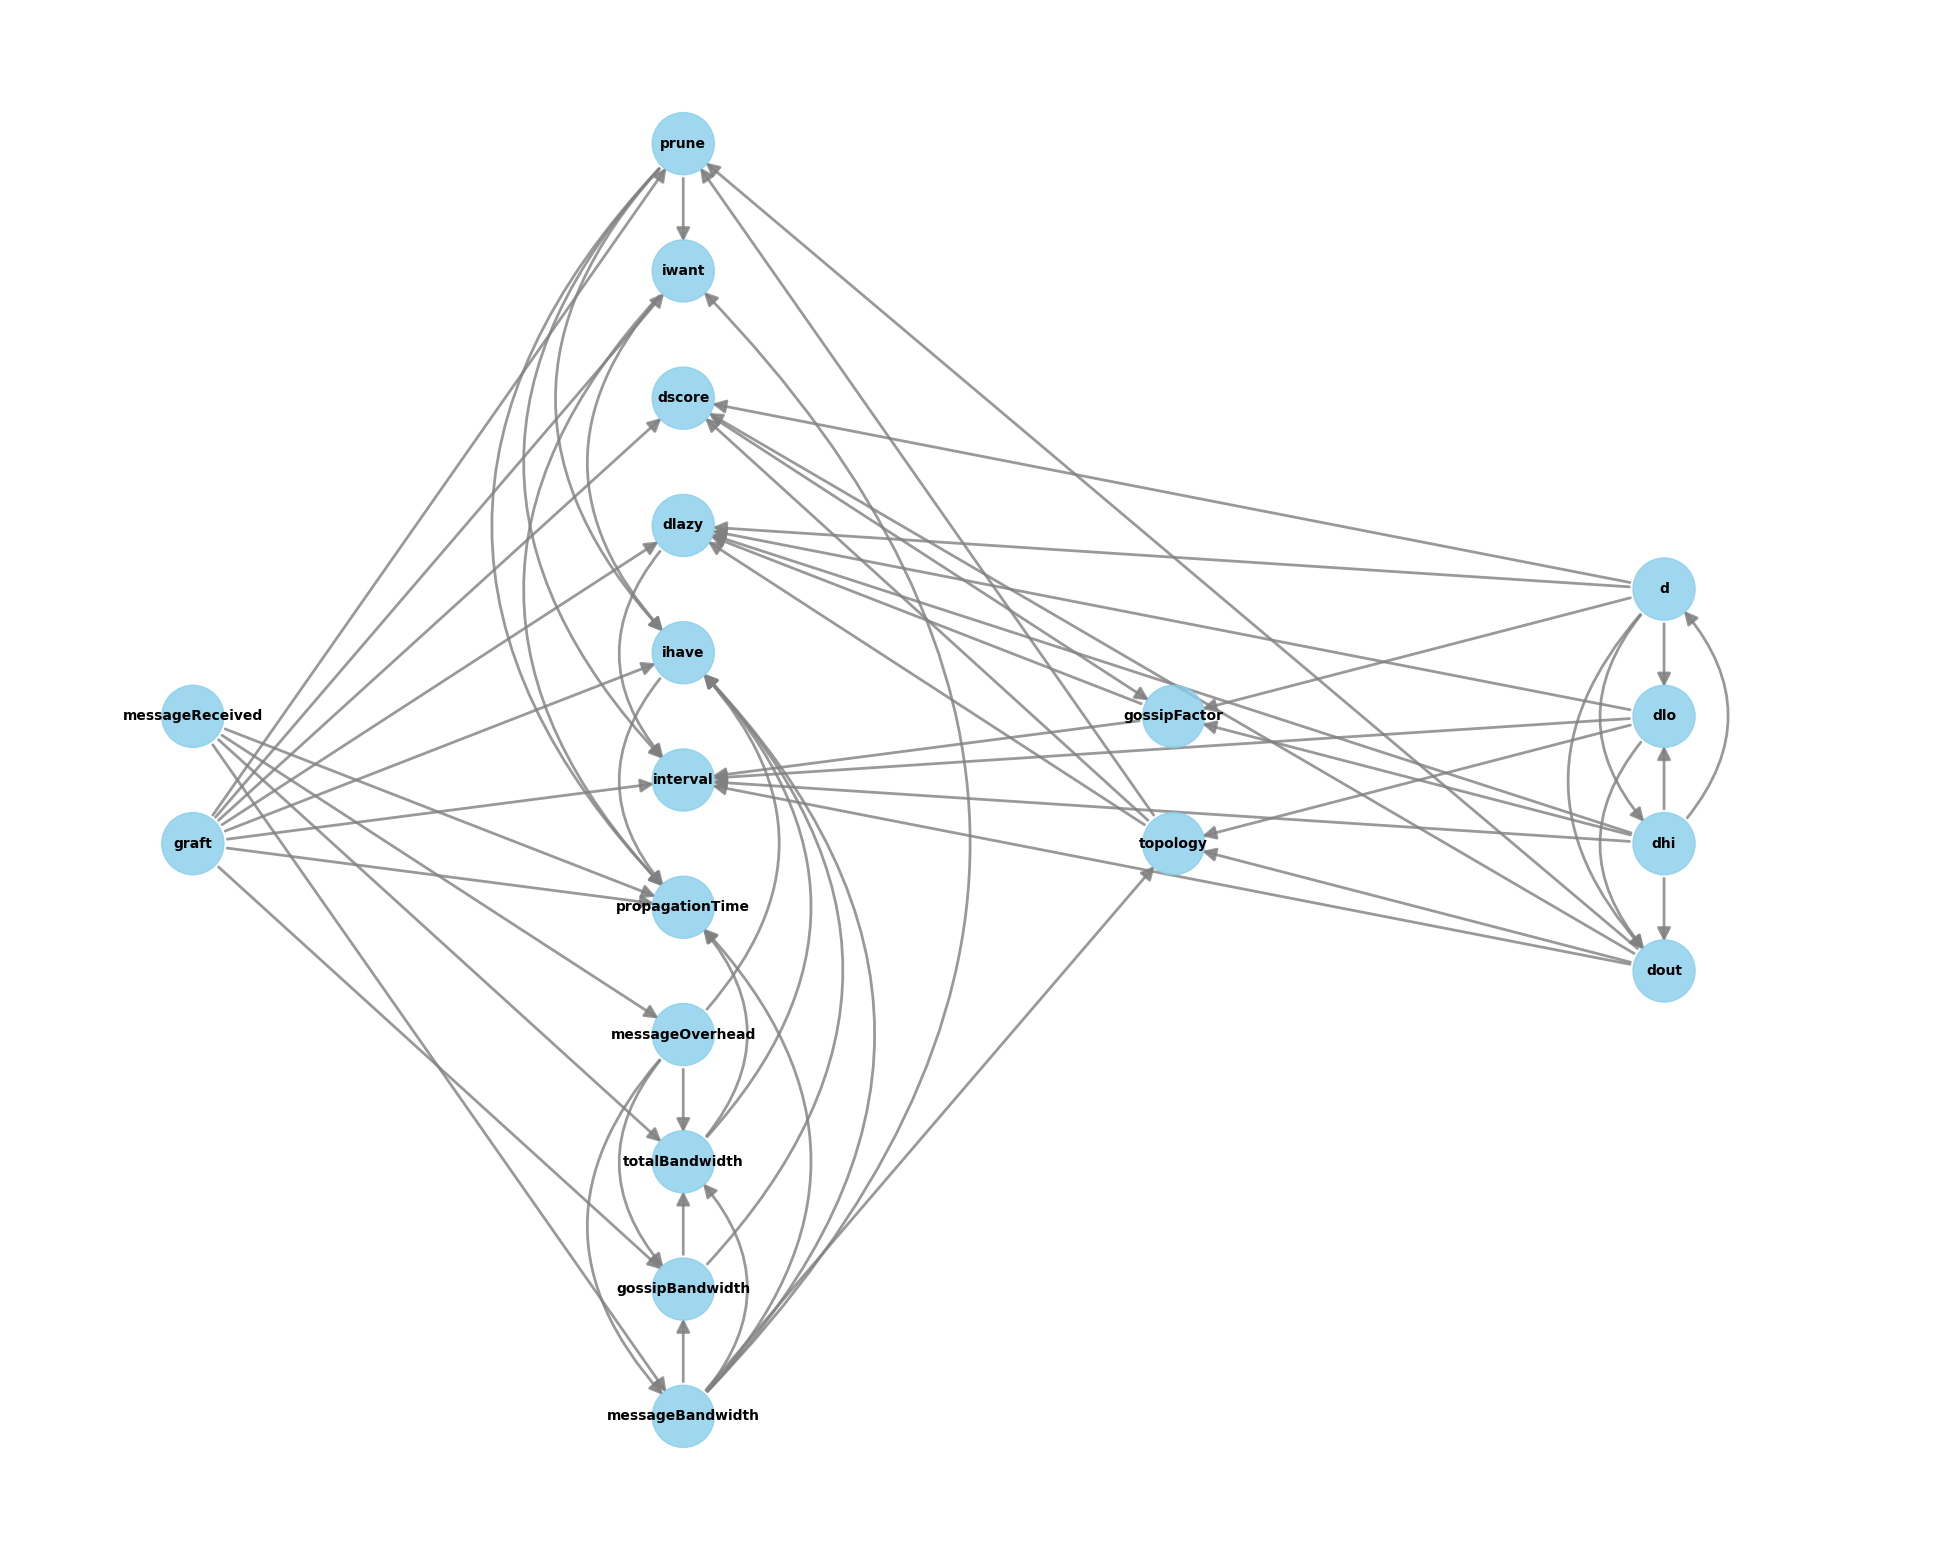

In [8]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'totalBandwidth',
            17:'gossipBandwidth',
            18:'messageBandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab

In [31]:
#Log normalization

# consolidateddiff = consolidated.diff().dropna()
consolidatedLog = consolidated

consolidatedLog['messageReceived'] = np.log(consolidated['messageReceived']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['graft'] = np.log(consolidated['graft']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['prune'] = np.log(consolidated['prune']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['iwant'] = np.log(consolidated['iwant']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['ihave'] = np.log(consolidated['ihave']).replace([np.inf, -np.inf], np.nan)
# consolidatedLog['gossipFactor'] = np.log10(consolidated['gossipFactor'])
consolidatedLog['propagationTime'] = np.log(consolidated['propagationTime']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['messageOverhead'] = np.log(consolidated['messageOverhead']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['totalBandiwdth'] = np.log(consolidated['totalBandwidth']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['gossipBandwidth'] = np.log(consolidated['gossipBandwidth']).replace([np.inf, -np.inf], np.nan)
consolidatedLog['messageBandwidth'] = np.log(consolidated['messageBandwidth']).replace([np.inf, -np.inf], np.nan)

consolidatedLog = consolidatedLog.fillna(0)

X = consolidatedLog[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'totalBandwidth', 'gossipBandwidth', 'messageBandwidth']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidatedLog.head(10)


/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/flav/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,messageBandwidth,totalBandwidth,gossipBandwidth,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology,totalBandiwdth
0,7.526581,8.228978,6.253829,0.0,0.0,0.0,0.000000,6.255750,8512.0,8.353026,8,6,12,4,8,2,0.25,1.0,0,9.049232
1,7.590809,6.169611,4.077537,0.0,0.0,0.0,5.849325,4.077537,1234.0,6.546785,8,6,12,4,8,2,0.25,1.0,0,7.118016
2,7.420967,8.290544,6.295266,0.0,0.0,0.0,0.000000,6.304449,9027.0,8.410498,8,6,12,4,8,2,0.25,1.0,0,9.107975
3,7.444663,6.156979,4.276666,0.0,0.0,0.0,5.860786,4.276666,1259.0,6.572283,8,6,12,4,8,2,0.25,1.0,0,7.138073
4,7.538849,8.216899,6.220590,0.0,0.0,0.0,0.000000,6.224558,8369.0,8.333511,8,6,12,4,8,2,0.25,1.0,0,9.032290
5,7.452000,6.287859,4.290459,0.0,0.0,0.0,5.849325,4.290459,1385.0,6.651572,8,6,12,4,8,2,0.25,1.0,0,7.233455
6,7.504534,8.140316,6.142037,0.0,0.0,0.0,0.000000,6.142037,7774.0,8.263333,8,6,12,4,8,2,0.25,1.0,0,8.958540
7,7.350025,6.666957,4.744932,0.0,0.0,0.0,5.834811,4.744932,1956.0,6.961296,8,6,12,4,8,2,0.25,1.0,0,7.578657
8,7.862338,8.147867,6.131226,0.0,0.0,0.0,0.000000,6.139885,7833.0,8.272060,8,6,12,4,8,2,0.25,1.0,0,8.966101
9,7.411408,6.658011,4.744932,0.0,0.0,0.0,5.837730,4.744932,1947.0,6.959399,8,6,12,4,8,2,0.25,1.0,0,7.574045


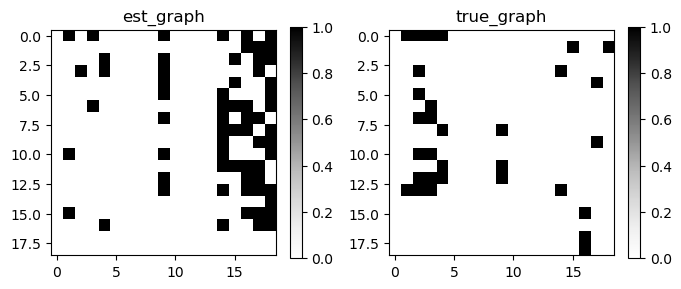

{'fdr': 0.8615, 'tpr': 0.2903, 'fpr': 0.4, 'shd': 75, 'nnz': 65, 'precision': 0.1385, 'recall': 0.2903, 'F1': 0.1875, 'gscore': 0.0}


In [35]:
# structure learning
priori = PrioriKnowledge(X.shape[1])
priori.add_forbidden_edges([(0,0),(0,5),(0,6),(0,7),(0,8),(0,10),(0,11),(0,12),(0,13),(1,0),(1,5),(1,6),(1,7),(1,8),(1,10),(1,11),(1,12),(1,13),
                            (2,0),(2,5),(2,6),(2,7),(2,8),(2,10),(2,11),(2,12),(2,13),(3,0),(3,5),(3,6),(3,7),(3,8),(3,10),(3,11),(3,12),(3,13),
                            (4,0),(4,5),(4,6),(4,7),(4,8),(4,10),(4,11),(4,12),(4,13),(5,0),(5,5),(5,6),(5,7),(5,8),(5,10),(5,11),(5,12),(5,13),
                            (6,0),(6,5),(6,6),(6,7),(6,8),(6,10),(6,11),(6,12),(6,13),(7,0),(7,5),(7,6),(7,7),(7,8),(7,10),(7,11),(7,12),(7,13),
                            (8,0),(8,5),(8,6),(8,7),(8,8),(8,10),(8,11),(8,12),(8,13),(9,0),(9,5),(9,6),(9,7),(9,8),(9,10),(9,11),(9,12),(9,13),
                            (10,0),(10,5),(10,6),(10,7),(10,8),(10,10),(10,11),(10,12),(10,13),(11,0),(11,5),(11,6),(11,7),(11,8),(11,10),(11,11),(11,12),(11,13),
                            (12,0),(12,5),(12,6),(12,7),(12,8),(12,10),(12,11),(12,12),(12,13),(13,0),(13,5),(13,6),(13,7),(13,8),(13,10),(13,11),(13,12),(13,13),
                            (14,0),(14,5),(14,6),(14,7),(14,8),(14,10),(14,11),(14,12),(14,13),(15,0),(15,5),(15,6),(15,7),(15,8),(15,10),(15,11),(15,12),(15,13),
                            (16,0),(16,5),(16,6),(16,7),(16,8),(16,10),(16,11),(16,12),(16,13),(16,15),(17,0),(17,5),(17,6),(17,7),(17,8),(17,10),(17,11),(17,12),(17,13),(17,15),
                            (18,0),(18,5),(18,6),(18,7),(18,8),(18,10),(18,11),(18,12),(18,13),(18,15)])#,(14,4),(16,17),(16,18)])
# priori.add_required_edges([(17, 16), 
#                            (18, 16),
#                            (6,2),
#                            (5,3)])
pc = PC(variant='original', priori_knowledge=priori)
pc.learn(X)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, true_causal_matrix, 'result')

# calculate metrics
mt = MetricsDAG(pc.causal_matrix, true_causal_matrix)
print(mt.metrics)

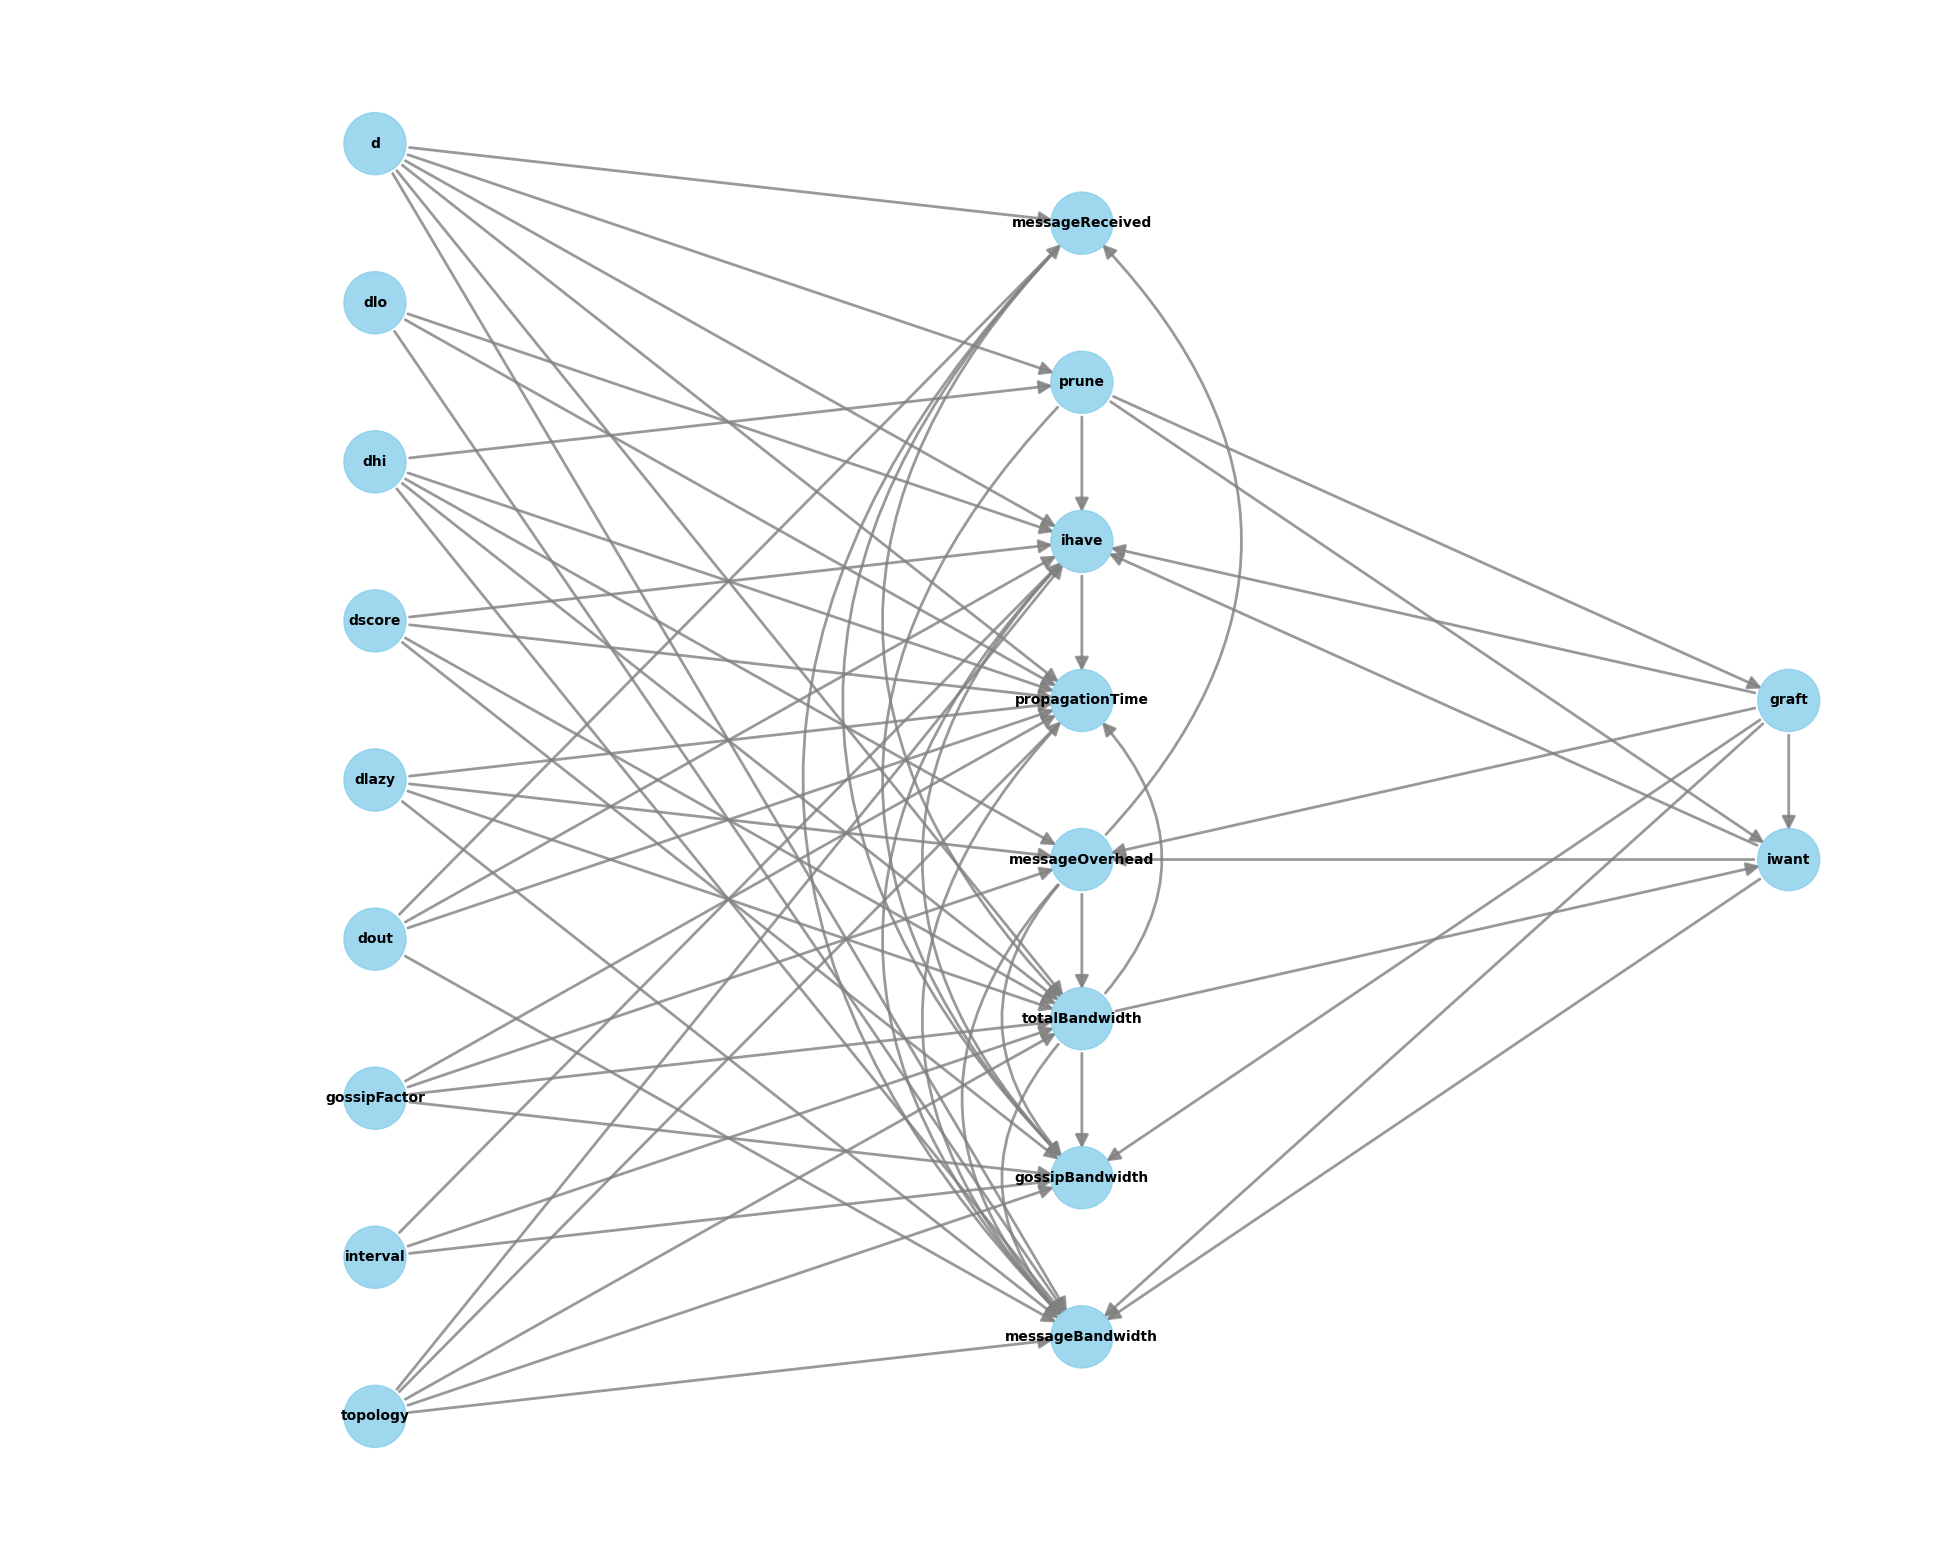

In [36]:
learned_causal_graph = nx.from_numpy_array(pc.causal_matrix, create_using=nx.DiGraph)

mapping = {0:'d',
            1:'messageReceived',
            2:'graft',
            3:'prune',
            4:'iwant',
            5:'dlo',
            6:'dhi',
            7:'dscore',
            8:'dlazy',
            9:'ihave',
            10:'dout',
            11:'gossipFactor',
            12:'interval',
            13:'topology',
            14:'propagationTime',
            15:'messageOverhead',
            16:'totalBandwidth',
            17:'gossipBandwidth',
            18:'messageBandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(30,30))

G=gcm.util.plot(H, figure_size=[25, 20])

nx.write_adjlist(H, "pc.adjlist")

# nx.draw(G)

# plt.savefig("PCNoPrioriKnowledge.png") # save as png
# plt.show() # displab